In [ ]:
# default_exp utils

In [ ]:
from theonerig.core import *

In [ ]:
from nbdev.test import test_eq
from nbdev.showdoc import *

# Utils
> Useful functiosn to reshape/arrange/reduce raw data into clean data to add to the record

In [ ]:
#export
import numpy as np
from typing import Dict, Tuple, Sequence, Union, Callable
import scipy.interpolate as interpolate
from scipy.ndimage import convolve1d

In [ ]:
#export
def extend_sync_timepoints(timepoints:np.ndarray, signals:np.ndarray, 
                           up_bound, low_bound=0) -> Tuple[DataChunk, DataChunk]:
    """From `timepoints` and `signals` list, extend it on the left so it includes `low_bound`, and extend it
    up to `up_bound`.
    Return the new timepoints and signals as DataChunk objets with the number of timepoints added to the left
    as a tuple.
    """
    assert len(timepoints) == len(signals)
    timepoints = np.array(timepoints)
    signals = np.array(signals)
    spb = np.mean(timepoints[1:]-timepoints[:-1]) #spf: sample_per_bin
        
    #Left and right side are just prolongation of the sample_times up 
    # from (0-sample_per_fr) to (len+sample_per_fr) so it covers all timepoints
    left_side  = np.arange(timepoints[0]-spb , low_bound - spb, -spb)[::-1].astype(int)
    right_side = np.arange(timepoints[-1]+spb,  up_bound + spb,  spb).astype(int)

    new_timepoints = np.concatenate((left_side, 
                                     timepoints, 
                                     right_side))
    
    timepoint_chunk = DataChunk(data=new_timepoints, idx=0, group="sync")
    signal_chunk    = DataChunk(data=signals, idx=len(left_side), group="sync")
    return (timepoint_chunk, signal_chunk, len(left_side))

It extends the timepoints by finding the typical distance between timepoints so it includes both left and right limits.

In [ ]:
extended_tp, extended_sig, n_left = extend_sync_timepoints([7900,8900,9900], signals=[1,2,3], up_bound=15000)

In [ ]:
print(extended_tp, end="\n\n")
print(extended_sig, end="\n\n")
print("N timepoints added to the left:",n_left)

Group: sync
Starting index: 0
Filling value: 0
[ -100   900  1900  2900  3900  4900  5900  6900  7900  8900  9900 10900
 11900 12900 13900 14900 15900]

Group: sync
Starting index: 8
Filling value: 0
[1 2 3]

N timepoints added to the left: 8


In [ ]:
#export
def align_sync_timepoints(timepoints:np.ndarray, signals:np.ndarray,
                          ref_timepoints:DataChunk, ref_signals:DataChunk, 
                          shift=None) -> DataChunk:
    """Align the `signals` of a `timepoints` timeserie to a reference `ref_timepoints` with the corresponding
    `ref_signals`. A `shift` can be directly specified, otherwise it will be searched by finding the maximum
    of the correlations of the two signals timeseries.
    Returns a DataChunk of the aligned timepoints"""
    assert len(timepoints) == len(signals)
    timepoints = np.array(timepoints)
    signals = np.array(signals)
    
    if shift is None: #If a shift is provided we use it, otherwise we use the max correlation
        shift = np.argmax(np.correlate(ref_signals, signals, mode="valid"))
        
    spb = np.mean(timepoints[1:]-timepoints[:-1]) #spf: sample_per_bin
    n_left  = ref_signals.idx + shift
    n_right = (len(ref_timepoints) 
               - len(timepoints) 
               - n_left)

    init_left  = timepoints[0]-spb
    init_right = timepoints[-1]+spb

    left_side  = np.arange(init_left , init_left-(spb*n_left+1), -spb)[:n_left][::-1].astype(int)
    right_side = np.arange(init_right, init_right+(spb*n_right+1), spb)[:n_right].astype(int)

    new_timepoints = np.concatenate((left_side, 
                                     timepoints, 
                                     right_side))
    return DataChunk(data=new_timepoints, idx=0, group="sync")

In [ ]:
#Aligning these signals 1,2,3 to the previously extended timepoints and signals
aligned_timepoints = align_sync_timepoints(timepoints=[1000,2000,3000], signals=[1,2,3],
                     ref_timepoints=extended_tp, ref_signals=extended_sig)

#We can observe 8 timepoints added to our function to match all existing frame of the reference.
print(aligned_timepoints)
test_eq(len(aligned_timepoints), len(extended_tp))

Group: sync
Starting index: 0
Filling value: 0
[-7000 -6000 -5000 -4000 -3000 -2000 -1000     0  1000  2000  3000  4000
  5000  6000  7000  8000  9000]


In [ ]:
#export
def downsample_to_timepoints(timepoints:np.ndarray, data:np.ndarray, 
                             ref_timepoints:DataChunk, group="data") -> DataChunk:
    """Downsample the `data` at the `timepoints` to a smaller array at the timepoints of `ref_timepoints`.
    Return a DataChunck of the downsampled data belonging to `group`."""
    
    assert len(timepoints) == len(data)
    timepoints = np.array(timepoints)
    data = np.array(data)
    
    start_idx = np.argmax(timepoints[0] <=ref_timepoints)
    stop_idx  = np.argmax(timepoints[-1]<=ref_timepoints)
    
    distance = (np.argmax(timepoints>ref_timepoints[start_idx+1]) 
            - np.argmax(timepoints>ref_timepoints[start_idx]))
    
    #Use numpy convolution to smooth. Could be generalized to higher dimension data
    # with scipy.ndimage.convolve1d
    kernel = np.ones(distance)/distance
    smooth_data = convolve1d(data, kernel, axis=0) #Smooting to avoid weird sampling
    new_data = interpolate.interp1d(timepoints, smooth_data, axis=0)(ref_timepoints[start_idx:stop_idx])

    idx = ref_timepoints.idx + start_idx
    return DataChunk(data=new_data, idx = idx, group=group)

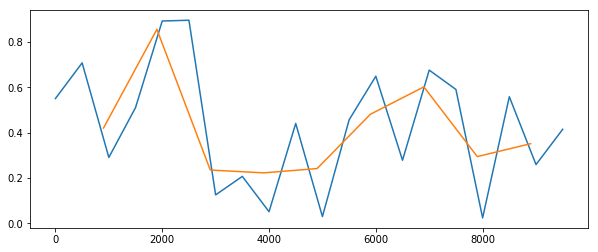

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(3)
too_large_data = np.random.rand(20)
data_timepoints = np.linspace(0,10000,20,endpoint=False, dtype=int)

downsamp_data = downsample_to_timepoints(data_timepoints, too_large_data, 
                                         ref_timepoints=extended_tp)

plt.figure(figsize=(10,4))
plt.plot(data_timepoints, too_large_data)
start,stop = downsamp_data.idx, downsamp_data.idx+len(downsamp_data)
plt.plot(extended_tp[start:stop], downsamp_data)

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted index.ipynb.
